# Data exploration and cleaning

In [1]:
import os
import re
import ast
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore

In [2]:
# Ensure the file exists in the current directory or provide the correct path
print("Current Working Directory:", os.getcwd())
file_path = 'data/charting-m-points.csv' 

data = pd.read_csv(file_path, encoding='latin1')
	
print(data.columns)

Current Working Directory: C:\Users\gushi\LTU\TennisStrokePrediction


C:\Users\gushi\AppData\Local\Temp\ipykernel_85240\2372044445.py:5: DtypeWarning: Columns (7,12,24,25,26,31,32,33,34,35,45,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='latin1')


Index(['match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', 'Gm#', 'TbSet',
       'TB?', 'TBpt', 'Svr', 'Ret', 'Serving', '1st', '2nd', 'Notes',
       '1stNoLet', '2ndNoLet', '1stSV', '2ndSV', '1stNoSV', '2ndNoSV', '1stIn',
       '2ndIn', 'isRally1st', 'isRally2nd', 'Sv1', 'Sv2', 'Rally', 'isAce',
       'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble',
       'rallyNoSpec', 'rallyNoError', 'rallyNoDirection', 'rallyLen',
       'PtWinner', 'isSvrWinner', 'PtsAfter', 'GmW', 'Gm1.1', 'Gm2.1', 'SetW',
       'Set1.1', 'Set2.1', 'RevTB', 'TBrev', 'rallyCount'],
      dtype='object')


## Data cleaning

In [3]:
dropped_features = ["TbSet", "TBpt", "1st", "2nd", "Notes", "1stNoLet", "2ndNoLet", "1stSV", "2ndSV", "1stNoSV", "2ndNoSV", "1stIn", "2ndIn", "isRally1st", "isRally2nd", "Rally", "rallyNoSpec", "rallyNoDirection", "PtWinner", "isSvrWinner", "PtsAfter", 'GmW', 'Gm1.1', 'Gm2.1', 'SetW', 'Set1.1', 'Set2.1', "RevTB", "TBrev", "rallyCount"]
kept_features = ["Pt", "Set1", "Set2", "Gm1", "Gm2", "Pts", "Gm#", "TB?", "rallyLen"]
processing_features = ["match_id", "Svr", "Ret", "Serving", "Sv1", "Sv2", "isAce", "isUnret",
                       "isRallyWinner", "isForced", "isUnforced", "isDouble", "rallyNoError"]

data = data.drop(columns=dropped_features, errors='ignore')
kept_features_data = data[kept_features].copy()
processing_features_data = data[processing_features].copy()
data = pd.concat([kept_features_data, processing_features_data], axis=1)
print("Missing values:")
print(data.isnull().sum())

Missing values:
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   1
Pts                   0
Gm#                   1
TB?                  75
rallyLen              0
match_id              0
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205088
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
dtype: int64


In [4]:
data = pd.concat([kept_features_data, processing_features_data], axis=1)
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   1
Pts                   0
Gm#                   1
TB?                  75
rallyLen              0
match_id              0
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205088
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
dtype: int64


# Process deduced features and compount features

In [5]:
def filter_data_by_player(data, target_player):
    """
    Filters the data for rows where the target player is playing.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Filtered dataset containing only rows where the target player is playing.
    """
    # Select "match_id" where target player is playing
    selected_match_ids = data.loc[data['Serving'] == target_player, 'match_id'].unique()

    # Filter rows in data where "match_id" is in the selected match_ids
    filtered_data = data[data['match_id'].isin(selected_match_ids)]
    
    return filtered_data

#In processing_data create "Svr" : 1 if the target player is serving, 0 if the target player is receiving
def create_svr_column(data, target_player): 
    """
    Creates a new column "Svr" in the dataset indicating if the target player is serving.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Updated dataset with the new "Svr" column.
    """
    data['Svr'] = np.where(data['Serving'] == target_player, 1, 0)
    return data

def align_score_to_target_perspective(df):
    score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
    df[['server_score_raw', 'receiver_score_raw']] = df['Pts'].str.split('-', expand=True)
    df['server_score'] = df['server_score_raw'].map(score_map)
    df['receiver_score'] = df['receiver_score_raw'].map(score_map)

    # Align to target player's perspective
    flip_mask = df['Svr'] == 0
    df.loc[flip_mask, ['server_score', 'receiver_score']] = df.loc[flip_mask, ['receiver_score', 'server_score']].values
    df.loc[flip_mask, ['server_score_raw', 'receiver_score_raw']] = df.loc[flip_mask, ['receiver_score_raw', 'server_score_raw']].values

    df.rename(columns={
        'server_score': 'player_score',
        'receiver_score': 'opponent_score'
    }, inplace=True)

    return df

In [6]:
def enrich_score_features(df):
    df['is_deuce'] = ((df['player_score'] == 3) & (df['opponent_score'] == 3)).astype(int)
    df['is_break_point'] = ((df['opponent_score'] >= 3) & (df['player_score'] < 3)).astype(int)
    df['is_game_point'] = ((df['player_score'] >= 3) & (df['opponent_score'] < 3)).astype(int)
    df['point_diff'] = df['player_score'] - df['opponent_score']
    return df

def enrich_match_context(df):
    df['total_sets_played'] = df['Set1'] + df['Set2']
    df['total_games_played'] = df['Gm1'] + df['Gm2']
    df['is_tiebreak'] = df['TB?'].astype(int)
    df['match_pressure_score'] = (
        df['is_break_point'] + df['is_game_point'] + df['is_tiebreak'] + df['is_deuce']
    )
    return df

def estimate_stamina(df):
    df['rally_intensity'] = df.groupby(['Set1', 'Set2', 'Gm#'])['rallyLen'].transform('mean')
    df['fatigue_index'] = (
        df['total_sets_played'] * 2 +
        df['total_games_played'] +
        df['rallyLen'] / 10 +
        df['is_tiebreak'] * 3
    )
    df['estimated_stamina'] = 1 / (1 + df['fatigue_index'])
    return df

In [7]:
# define shot types to be mapped for our unforced error and winners array
shot_types = [
    'f', 'b',  # groundstrokes
    'r', 's',  # slices
    'v', 'z',  # volleys
    'o', 'p',  # overheads
    'u', 'y',  # drop shots
    'l', 'm',  # lobs
    'h', 'i',  # half-volleys
    'j', 'k',  # swinging volleys
    #'t', 'q'   # trick shots and unknown shots
]

# generate combinations with directions 1, 2, 3
shot_vocab = {f"{shot}{n}": idx for idx, (shot, n) in enumerate(
    (s, i) for s in shot_types for i in [1, 2, 3]
)}


def process_rally_data(df, shot_vocab):
    sequence_data = []
    direction_dict = {'1', '2', '3'}
    serve_dict={'4','5','6'}

    for _, row in df.iterrows():
        isServe = row['Svr'] == 1
        rally = str(row['rallyNoError'])

        if pd.isna(rally) or len(rally) < 2:
            continue

        debug_logs = []
        tokens = []

        # First shot: allow 1–2 digits
        match = re.match(r'^([a-zA-Z])(\d+)', rally)
        if not match:
            continue

        first_letter = match.group(1)
        digits = match.group(2)[:2]
        first_token = first_letter + digits[0]

        if first_token in shot_vocab:
            tokens.append(first_token)
        else:
            continue
        idx = len(match.group(0))

        # Extract remaining shots
        while idx + 2 <= len(rally):
            segment = rally[idx:idx+3]
            debug_logs.append(f"[{idx}] Segment: '{segment}'")

            if re.match(r'^[a-zA-Z]\d[a-zA-Z]$', segment):
                token = segment[0] + segment[1]
                debug_logs.append(f"[{idx}] Pattern A: {segment}")

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 2

            elif re.match(r'^[a-zA-Z]\d\d$', segment):
                debug_logs.append(f"[{idx}] Pattern B: {segment}")
                token1 = segment[0] + segment[1]
                token2 = segment[0] + segment[2]

                if segment[1] in direction_dict and token1 in shot_vocab:
                    tokens.append(token1)

                elif segment[2] in direction_dict and token2 in shot_vocab:
                    tokens.append(token2)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid tokens: {token1}, {token2}")
                    break
                idx += 3

            elif re.match(r'^[a-zA-Z][a-zA-Z]\d$', segment):
                debug_logs.append(f"[{idx}] Pattern C: {segment}")
                token = segment[1] + segment[2]

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 3

            else:
                debug_logs.append(f"[{idx}] Pattern D (Fallback): {segment}")

                if idx + 1 < len(rally):
                    ch1, ch2 = rally[idx], rally[idx + 1]
                    token = ch1 + ch2

                    if ch1.isalpha() and ch2 in direction_dict and token in shot_vocab:
                        tokens.append(token)
                        idx += 2

                    else:
                        debug_logs.append(f"[{idx}] ❌ Invalid fallback token: {token}")
                        break
                else:
                    break

        # Skip rallies with invalid parsing
        if any(log.startswith("❌") for log in debug_logs):
            print(f"\n🔍 Invalid rally at row {row.name}: {rally}")
            for log in debug_logs:
                print(log)
            continue

        # --- Serve Logic ---
        if not pd.isna(row['Sv1']) and row['Sv1'][0] in serve_dict:
            if not pd.isna(row['Sv2']) and row['Sv2'][0] in serve_dict:
                full_rally = [row['Sv1'][0], row['Sv2'][0]] + tokens
            else:
                full_rally = ['0', row['Sv1'][0]] + tokens
        else:
            continue

        # --- Label Arrays ---
        winner_array = np.zeros(48)
        unforced_array = np.zeros(48)

        final_shot = tokens[-1]
        idx = shot_vocab.get(final_shot, None)
        if idx is not None:
            if row['isRallyWinner']:
                winner_array[idx] += 1
            elif row['isUnforced']:
                unforced_array[idx] += 1

        # --- 3-Shot Sequence Construction ---
        i = 0 if isServe else 1
        while i + 3 < len(full_rally):
            new_row = row.to_dict()
            new_row['shot1'] = full_rally[i]
            new_row['shot2'] = full_rally[i + 1]
            new_row['shot3'] = full_rally[i + 2]
            new_row['shot4'] = full_rally[i + 3]
            new_row['winner_array'] = winner_array.copy()
            new_row['unforced_array'] = unforced_array.copy()
            sequence_data.append(new_row)
            i += 2

    return pd.DataFrame(sequence_data)


In [8]:
def validate_column_types(df):
    expected_types = {
        'Pt': 'int64', 'Set1': 'int64', 'Set2': 'int64', 'Gm1': 'int64',
        'Gm2': 'float64', 'Pts': 'object', 'Gm#': 'object',
        'TB?': 'float64', 'rallyLen': 'int64'
    }
    for col, expected in expected_types.items():
        if col in df.columns and df[col].dtype != expected:
            print(f"Column {col} has type {df[col].dtype}, expected {expected}")
    return df

def validate_score_format(df):
    valid_scores = {'0', '15', '30', '40', 'AD'}
    df[['server_score_raw', 'receiver_score_raw']] = df['Pts'].str.split('-', expand=True)
    invalid_scores = df[
        (~df['server_score_raw'].isin(valid_scores)) |
        (~df['receiver_score_raw'].isin(valid_scores))
    ]
    if not invalid_scores.empty:
        print("Invalid score entries found:")
        print(invalid_scores[['Pts']].drop_duplicates())
    return df[~df.index.isin(invalid_scores.index)]

def validate_set_game_counts(df):
    invalid_sets = df[(df['Set1'] > 3) | (df['Set2'] > 3)]
    invalid_games = df[(df['Gm1'] > 7) | (df['Gm2'] > 7)]
    df = df.drop(invalid_sets.index.union(invalid_games.index))
    return df

def validate_tennis_data(df):
    df = validate_column_types(df)
    df = validate_score_format(df)
    df = validate_set_game_counts(df)
    return df

def preprocess_numeric_columns(df):
    # Clean Gm# to integer
    if 'Gm#' in df.columns:
        df['Gm#'] = df['Gm#'].apply(lambda x: int(re.match(r'\d+', str(x)).group()) if re.match(r'\d+', str(x)) else 0)

    # Ensure score columns are integers where applicable
    score_cols = ['Set1', 'Set2', 'Gm1', 'Gm2']
    for col in score_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Rally length cleanup
    if 'rallyLen' in df.columns:
        df['rallyLen'] = pd.to_numeric(df['rallyLen'], errors='coerce').fillna(0).astype(int)

    return df

def handle_missing_values(df):
    df['TB?'] = df['TB?'].fillna(0)
    df.dropna(subset=['Gm2', 'Gm#'], inplace=True)
    return df

### Acutual processing

In [9]:
processing_features.append("Pts")
processing_features.append("receiver_score_raw")
processing_features.append("server_score_raw")

def process_tennis_data(data, target_player="RF"):
    df = data.copy()
    df = filter_data_by_player(df, target_player)
    df = create_svr_column(df, target_player)
    df = validate_tennis_data(df)    
    df = align_score_to_target_perspective(df)
    df = process_rally_data(df, shot_vocab=shot_vocab)
    df = enrich_score_features(df)
    df = enrich_match_context(df)
    df = estimate_stamina(df)
    df = handle_missing_values(df)
    df = preprocess_numeric_columns(df)
    df = df.drop(columns=processing_features, errors='ignore')
    return df

processed_data = process_tennis_data(data, target_player="RF")

Invalid score entries found:
          Pts
7108      0-1
7109      1-1
7110      1-2
7111      2-2
7112      2-3
...       ...
266584  16-17
266585  17-17
266586  17-18
266587  18-18
266588  19-18

[77 rows x 1 columns]


In [10]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69077 entries, 0 to 69076
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Pt                    69077 non-null  int64  
 1   Set1                  69077 non-null  int32  
 2   Set2                  69077 non-null  int32  
 3   Gm1                   69077 non-null  int32  
 4   Gm2                   69077 non-null  int32  
 5   Gm#                   69077 non-null  int64  
 6   TB?                   69077 non-null  float64
 7   rallyLen              69077 non-null  int32  
 8   player_score          69077 non-null  int64  
 9   opponent_score        69077 non-null  int64  
 10  shot1                 69077 non-null  object 
 11  shot2                 69077 non-null  object 
 12  shot3                 69077 non-null  object 
 13  shot4                 69077 non-null  object 
 14  winner_array          69077 non-null  object 
 15  unforced_array     

In [11]:
print("Unique labels in shot1:", np.unique(processed_data['shot4']))

Unique labels in shot1: ['b1' 'b2' 'b3' 'f1' 'f2' 'f3' 'h1' 'h2' 'h3' 'i1' 'i2' 'i3' 'j1' 'j2'
 'j3' 'k1' 'k3' 'l1' 'l2' 'l3' 'm1' 'm2' 'm3' 'o1' 'o2' 'o3' 'p1' 'p2'
 'p3' 'r1' 'r2' 'r3' 's1' 's2' 's3' 'u1' 'u2' 'u3' 'v1' 'v2' 'v3' 'y1'
 'y2' 'y3' 'z1' 'z2' 'z3']


In [12]:
import numpy as np
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

def parse_array_column(x, size=48):
    try:
        if isinstance(x, str):
            clean = re.sub(r'\s+', ',', x.strip("[]"))
            return np.array(ast.literal_eval(f"[{clean}]"))
    except:
        pass
    return np.zeros(size)

def apply_log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

def clip_outliers(df, columns, lower=0.01, upper=0.99):
    for col in columns:
        q_low = df[col].quantile(lower)
        q_high = df[col].quantile(upper)
        df[col] = df[col].clip(lower=q_low, upper=q_high)
    return df

def scale_features(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def validate_encoding(df, shot_cols):
    return {col: pd.api.types.is_integer_dtype(df[col]) for col in shot_cols}

def encode_shot_columns(df, shot_cols):
    for col in shot_cols:
        encoded_col = col + '_encoded'
        if encoded_col not in df.columns:
            le = LabelEncoder()
            df[encoded_col] = le.fit_transform(df[col].astype(str))
    return df

def plot_distributions(df, columns):
    for col in columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()


Clipped Set1: [0.00, 2.00]
Clipped Set2: [0.00, 2.00]
Clipped Gm1: [0.00, 6.00]
Clipped Gm2: [0.00, 6.00]
Clipped Gm#: [1.00, 50.00]
Clipped is_deuce: [0.00, 1.00]
Clipped is_break_point: [0.00, 1.00]
Clipped is_game_point: [0.00, 1.00]
Clipped is_tiebreak: [0.00, 0.00]
Clipped player_score: [0.00, 4.00]
Clipped opponent_score: [0.00, 4.00]
Clipped point_diff: [-3.00, 3.00]
Clipped rallyLen: [2.00, 25.00]
Clipped rally_intensity: [4.83, 12.69]
Clipped fatigue_index: [0.50, 16.80]
Clipped estimated_stamina: [0.06, 0.67]
Clipped total_sets_played: [0.00, 4.00]
Clipped total_games_played: [0.00, 11.00]
Clipped match_pressure_score: [0.00, 1.00]

Encoding Check: {'shot1_encoded': True, 'shot2_encoded': True, 'shot3_encoded': True, 'shot4_encoded': True}

No missing values.


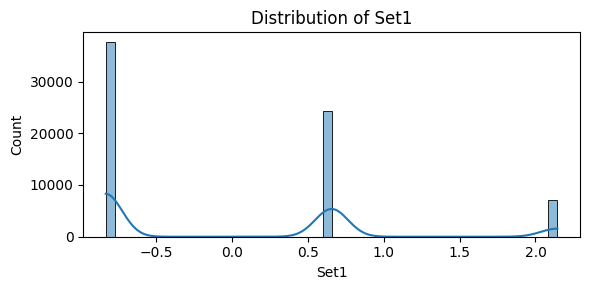

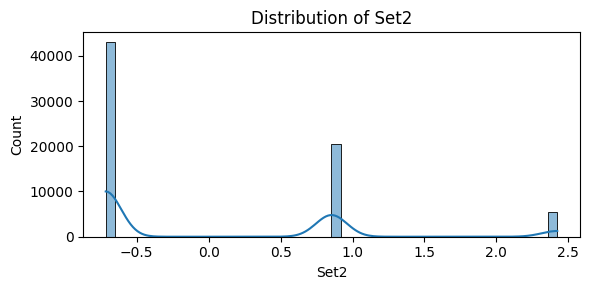

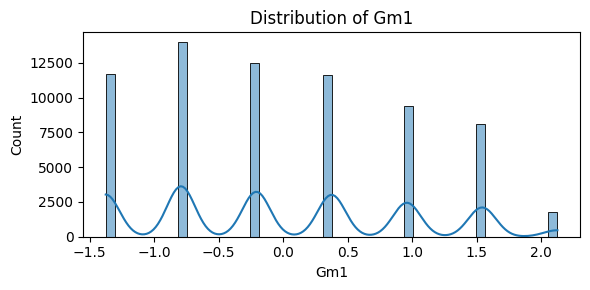

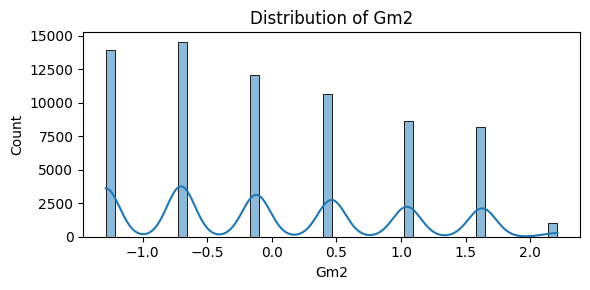

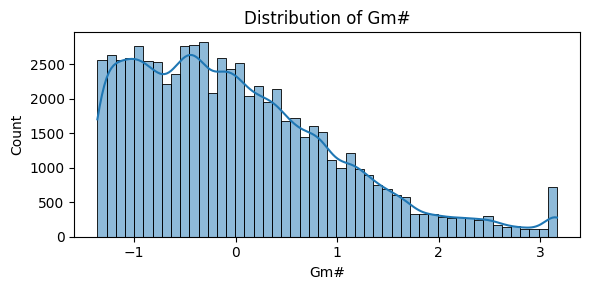

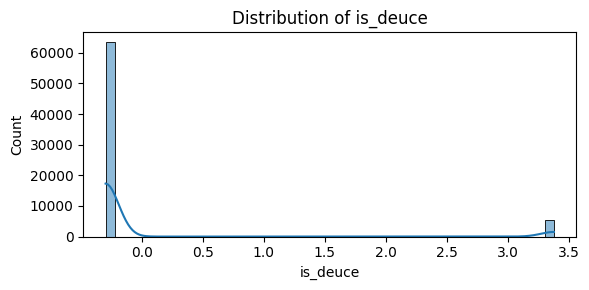

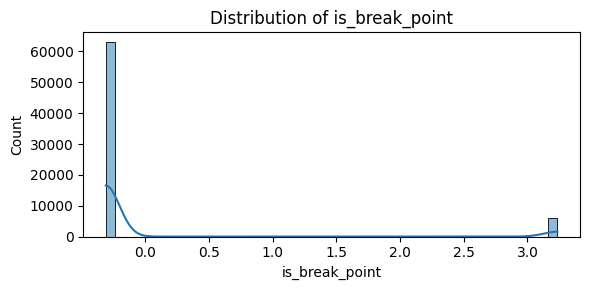

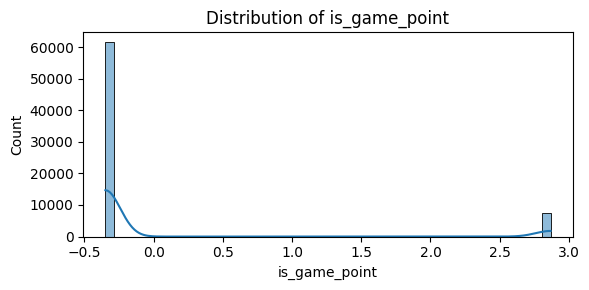

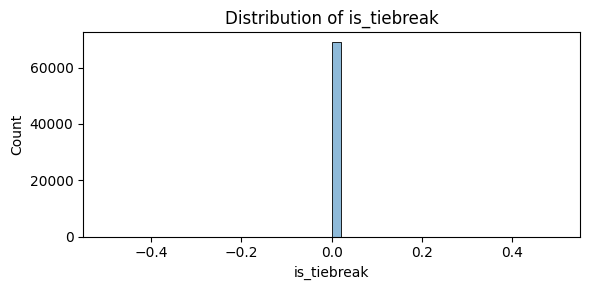

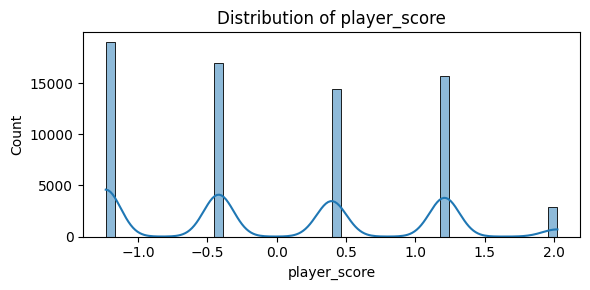

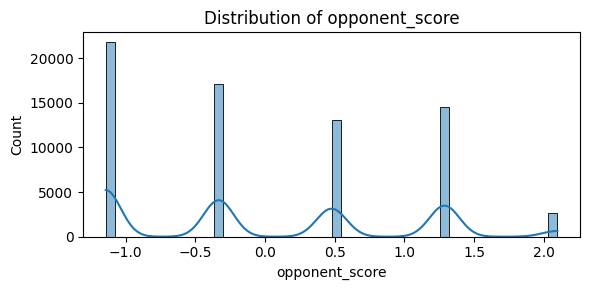

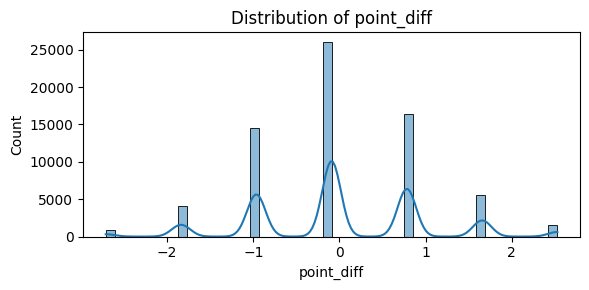

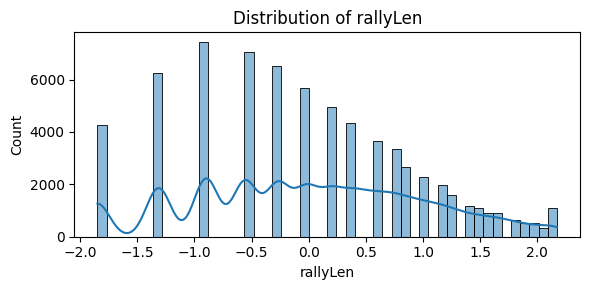

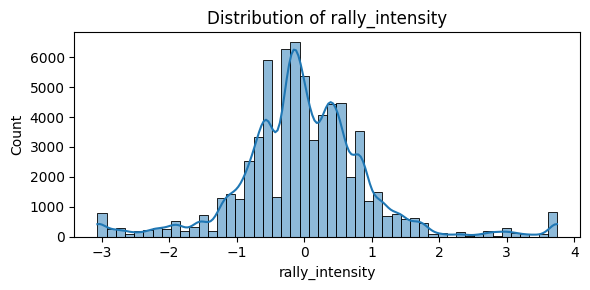

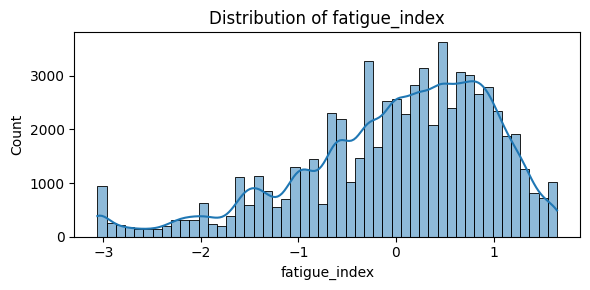

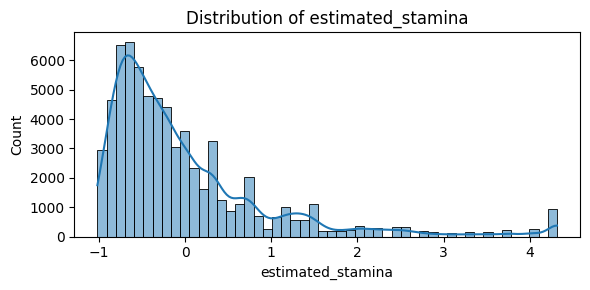

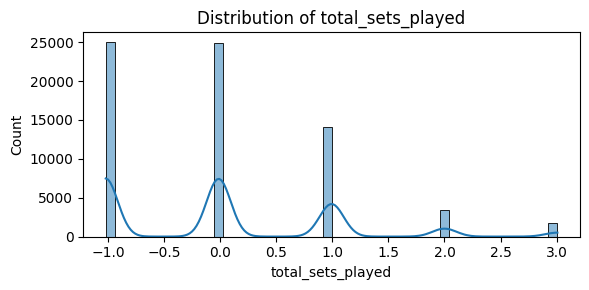

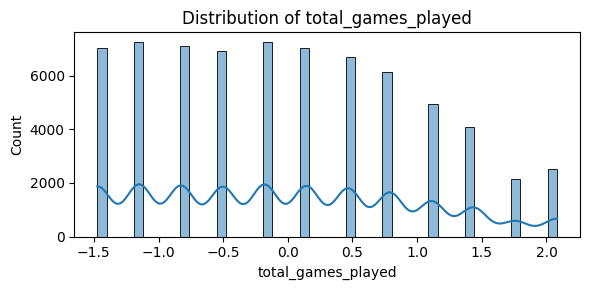

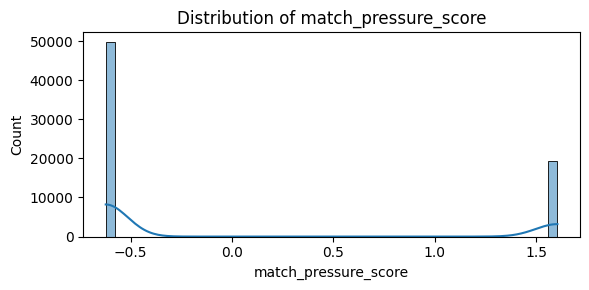

In [13]:
from sklearn.preprocessing import LabelEncoder

def clean_and_finalize_data(df):
    df = df.copy()

    # Parse array columns
    df['winner_array'] = df['winner_array'].apply(lambda x: parse_array_column(x, 48))
    df['unforced_array'] = df['unforced_array'].apply(lambda x: parse_array_column(x, 48))

    # Feature categories
    numeric_cols = [
        'Set1', 'Set2', 'Gm1', 'Gm2', 'Gm#','is_deuce', 'is_break_point', 'is_game_point', 'is_tiebreak',
        'player_score', 'opponent_score', 'point_diff', 'rallyLen',
        'rally_intensity', 'fatigue_index', 'estimated_stamina',
        'total_sets_played', 'total_games_played', 'match_pressure_score'
    ]
    log_cols = ['rallyLen', 'fatigue_index', 'match_pressure_score', 'estimated_stamina']
    shot_cols = ['shot1', 'shot2', 'shot3', 'shot4']
    encoded_cols = [col + '_encoded' for col in shot_cols]

    # Encode shot columns if not already encoded
    for col in shot_cols:
        encoded_col = col + '_encoded'
        if encoded_col not in df.columns:
            le = LabelEncoder()
            df[encoded_col] = le.fit_transform(df[col].astype(str))

    # Clip outliers
    for col in numeric_cols:
        low = df[col].quantile(0.01)
        high = df[col].quantile(0.99)
        df[col] = df[col].clip(low, high)
        print(f"Clipped {col}: [{low:.2f}, {high:.2f}]")
        
    # Log transform
    for col in log_cols:
        df[col] = np.log1p(df[col])

    # Scale
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Validate encoding
    encoding_check = {col: pd.api.types.is_integer_dtype(df[col]) for col in encoded_cols}
    print("\nEncoding Check:", encoding_check)

    # Check missing values
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing values found:\n", missing[missing > 0])
    else:
        print("\nNo missing values.")

    plot_distributions(df, numeric_cols)

    return df

cleaned_data = clean_and_finalize_data(processed_data)

In [14]:
cleaned_data.to_csv("data/cleaned_data.csv", index=False)